# The Batte of Neighborhoods

## Introduction, Business Problem

### Background

Our boss asks me, a data scientist, to help him because he wants to start a new business as he already own some restaurant in New York. He wants to expand his area of effect and to settle in other venues that are good for tourists and inhabitants. He noticed that tourists are loving having a coffee during their trip/holidays, so he thinks we should create a Café so people can enjoy their life while we could grow as business men and get bigger. As I am a french loving italians coffee he knew I would like to work with him on this. But he tells me it might not be exactly a café we need to open, but maybe a related venue similar to it as people also love eating. So he also tells he is open to any recommandation from me.

We want to open a café (or something alike) in New York City as people love to gather in a place to drink a hot beverage or a taste stunning beauty. We will need to know where to establish our café so we have the best chances to start our new business. As we may not choose a place if it is too different from what we want we will establish a top 5 of the best area.

## Data required

We will focus on the activity and the income of an area. We will need to find nearby good cafés having good ratings.

The aim of this project is to solve the problem so we will need something that works.

What data will we need :
* Boroughs
* Neighborhoods
* Locations
* Venues (locations, category)
* Maybe some demographics can be interesting
* Income (average)

We will find these data using foursquare API.

We will treat each data available in the New York City json file so we get the borough with the most café venues. Then in this Borough we want to find clusters so we can understand where and how to settle a new Café. We will make a top 5 so we know what's best to exploit.

## Imports and Packages

In [1]:
import numpy as np
import pandas as pd
import geocoder
import requests
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import re
import bs4 as bs
import urllib
import urllib.request

## Foursquare Credentials

In [2]:
CLIENT_ID = 'FA0TFZTR0RWPD4OCSHAQGEFCSS4SXVPDK50VHT5KPFWLRZTU' # your Foursquare ID
CLIENT_SECRET = 'JUADW5XDGYN5HCJFYUQSDKLRLNGUVMFMYVCZW1VARRF4Y5IO' # your Foursquare Secret
VERSION = '20180604'

# Methodology

## Getting New York Data

Opening the new york json file and fetching the data. The source of the data : it's the one we used in the course labs.

In [3]:
with open('ny.json') as json_data:
    newyork_data = json.load(json_data)

Get the features out of the data

In [4]:
neighborhoods_data = newyork_data['features']

Creating a dataframe from it

In [5]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude


Populating the dataframe

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Getting the number of boroughs and neighborhoods

In [8]:
print('{} boroughs\n{} neighborhoods.'.format(len(neighborhoods['Borough'].unique()),neighborhoods.shape[0]))

5 boroughs
306 neighborhoods.


Getting New York City coordinates

In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('New York City coordinates: {}, {}.'.format(latitude, longitude))

New York City coordinates: 40.7127281, -74.0060152.


Creating a map of New York for vizualisation

In [10]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

This map visualization already gives us informations about how new york is geometricaly.
We can aknoledge the is a center area: population density could bring us an information on where it would be ideal to settle our business. cf. Discussion (just before the conclusion of the notebook)

Getting all Borough so we can treat them separatly

In [11]:
neighborhoods['Borough'].unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

Getting longitude and latitude of all the New York Boroughs

In [12]:
geolocator = Nominatim(user_agent="ny_explorer")

bronx = neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)
address = 'Bronx, NY'
location = geolocator.geocode(address)
bronx_lat = location.latitude
bronx_lon = location.longitude
print('Bronx: {}, {}.'.format(bronx_lat, bronx_lon))

manhattan = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
address = 'Manhattan, NY'
location = geolocator.geocode(address)
manhattan_lat = location.latitude
manhattan_lon = location.longitude
print('Manhattan: {}, {}.'.format(manhattan_lat, manhattan_lon))

brooklyn = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
address = 'Brooklyn, NY'
location = geolocator.geocode(address)
brooklyn_lat = location.latitude
brooklyn_lon = location.longitude
print('Brooklyn: {}, {}.'.format(brooklyn_lat, brooklyn_lon))

queens = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
address = 'Queens, NY'
location = geolocator.geocode(address)
queens_lat = location.latitude
queens_lon = location.longitude
print('Queens: {}, {}.'.format(queens_lat, queens_lon))

staten_island = neighborhoods[neighborhoods['Borough'] == 'Staten Island'].reset_index(drop=True)
address = 'Staten Island, NY'
location = geolocator.geocode(address)
staten_island_lat = location.latitude
staten_island_lon = location.longitude
print('Staten Island: {}, {}.'.format(staten_island_lat, staten_island_lon))

Bronx: 40.8466508, -73.8785937.
Manhattan: 40.7896239, -73.9598939.
Brooklyn: 40.6501038, -73.9495823.
Queens: 40.7498243, -73.7976337.
Staten Island: 40.5834557, -74.1496048.


Plotting a Map for each Brorough in New York so we have a representation of each

In [13]:
def plot_map(data, lat, lon):
    map1 = folium.Map(location=[lat, lon], zoom_start=11)

    for lat, lng, label in zip(data['Latitude'], data['Longitude'], data['Neighborhood']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map1)  
    return map1

In [14]:
bronx_map = plot_map(bronx, bronx_lat, bronx_lon)
bronx_map

In [15]:
manhattan_map = plot_map(manhattan, manhattan_lat, manhattan_lon)
manhattan_map

In [16]:
brooklyn_map = plot_map(brooklyn, brooklyn_lat, brooklyn_lon)
brooklyn_map

In [17]:
queens_map = plot_map(queens, queens_lat, queens_lon)
queens_map

In [18]:
staten_island_map = plot_map(staten_island, staten_island_lat, staten_island_lon)
staten_island_map

## Foursquare

Let's go through all neighborhoods and get the best borough to settle in.

In [19]:
borough = [bronx, manhattan, brooklyn, queens, staten_island]

print("Bronx: {} neigborhoods".format(bronx['Neighborhood'].shape[0]))
print("Manhattan: {} neigborhoods".format(manhattan['Neighborhood'].shape[0]))
print("Brooklyn: {} neigborhoods".format(brooklyn['Neighborhood'].shape[0]))
print("Queens: {} neigborhoods".format(queens['Neighborhood'].shape[0]))
print("Staten Island: {} neigborhoods".format(staten_island['Neighborhood'].shape[0]))

Bronx: 52 neigborhoods
Manhattan: 40 neigborhoods
Brooklyn: 70 neigborhoods
Queens: 81 neigborhoods
Staten Island: 63 neigborhoods


Remind that there are about 306 neighborhoods in NY and we can make 950 calls max per day with foursquare.
That would make 3 calls per neighborhood (950/306).
Here we choose to only focus on Queens for technical reasons. And then we can make 10 calls for each neigborhood in queens which makes 810 calls in total.

Now let's test the validity of one call :

In [20]:
coffee_shop = '4bf58dd8d48988d1e0931735'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION,
        'coffee',
        queens.loc[0, 'Latitude'], 
        queens.loc[0, 'Longitude'],
        500, 
        1)  

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '608d6726be490c4fa815235c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'warning': {'text': 'There aren\'t a lot of results for "coffee." Try something more general, reset your filters, or expand the search area.'},
  'headerLocation': 'Astoria',
  'headerFullLocation': 'Astoria, Queens',
  'headerLocationGranularity': 'neighborhood',
  'query': 'coffee',
  'totalResults': 18,
  'suggestedBounds': {'ne': {'lat': 40.773008597854925,
    'lng': -73.90972309237958},
   'sw': {'lat': 40.76400858885492, 'lng': -73.9215843937051}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bc75a2914d795215b3767e9',
       'name': 'Café Via Espresso',
       'location': {'addr

Now let's call some of the coffee shops from Queens in NY

In [21]:
LIMIT = 10
radius = 500

url = []
res = []

coffee_shop = 'coffee'
for index, row in queens.iterrows():
    
    curr_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION,
        coffee_shop,
        row['Latitude'], 
        row['Longitude'],
        radius, 
        LIMIT)
    
    url.append(curr_url)
    
    res.append(requests.get(curr_url).json())


In [22]:
res[0]

{'meta': {'code': 200, 'requestId': '608d6729ae879258d1f2f03a'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Astoria',
  'headerFullLocation': 'Astoria, Queens',
  'headerLocationGranularity': 'neighborhood',
  'query': 'coffee',
  'totalResults': 18,
  'suggestedBounds': {'ne': {'lat': 40.773008597854925,
    'lng': -73.90972309237958},
   'sw': {'lat': 40.76400858885492, 'lng': -73.9215843937051}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bc75a2914d795215b3767e9',
       'name': 'Café Via Espresso',
       'location': {'address': '2409 Steinway St',
        'crossStreet': 'at Astoria Blvd.',
        'lat': 40.7686759,
        'lng': -73.9108511,
        'labeledLatLng

Let's clean the jsons

In [23]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [24]:
nearby_venues_list = []
filtered_columns = ['venue.location.city','venue.name','venue.categories','venue.location.lat','venue.location.lng']

i = 0
for re in res:
    venues = re['response']['groups'][0]['items']
    if not venues:
        i += 1
    else:
        nearby_venues = json_normalize(venues)
        nearby_venues = nearby_venues.loc[:, filtered_columns]

        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
        nearby_venues_list.append(nearby_venues)
    
nb_venues = 0
for nv in nearby_venues_list:
    nb_venues += nv.shape[0]
    
print('{} venues were returned by Foursquare.'.format(nb_venues), " and {} json element had empty items and could not be treated which makes {} treated elements.".format(i, nb_venues-i))

nearby_venues_list[0].head()

246 venues were returned by Foursquare.  and 16 json element had empty items and could not be treated which makes 230 treated elements.


C:\Anaconda\envs\hosk\lib\site-packages\pandas\core\indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,city,name,categories,lat,lng
0,Astoria,Café Via Espresso,Café,40.768676,-73.910851
1,Queens,Gossip Coffee,Coffee Shop,40.764522,-73.916462
2,Astoria,Avenue Cafe,Café,40.765148,-73.917389
3,Astoria,Starbucks,Coffee Shop,40.770030,-73.918510
4,Astoria,Café To Go Creperie,Café,40.766831,-73.920441


In [25]:
print(nearby_venues_list[0]['city'])

0    Astoria
1     Queens
2    Astoria
3    Astoria
4    Astoria
5    Astoria
6    Astoria
7     Queens
8    Astoria
9    Astoria
Name: city, dtype: object


Let's get number of coffee venues per neighborhoods

In [26]:
for re, ven in zip(res, nearby_venues_list):
    print("There are {} venues in {} !".format(ven.count()[0], ven['city'][0]))

There are 10 venues in Astoria !
There are 10 venues in Woodside !
There are 8 venues in Jackson Heights !
There are 10 venues in Jackson Heights !
There are 5 venues in Howard Beach !
There are 3 venues in Corona !
There are 3 venues in Queens !
There are 5 venues in Kew Gardens !
There are 5 venues in Queens !
There are 10 venues in Flushing !
There are 10 venues in Long Island City !
There are 5 venues in Sunnyside !
There are 4 venues in East Elmhurst !
There are 3 venues in Maspeth !
There are 5 venues in Ridgewood !
There are 1 venues in Glendale !
There are 7 venues in Rego Park !
There are 1 venues in Woodhaven !
There are 3 venues in Jamaica !
There are 1 venues in South Ozone Park !
There are 4 venues in College Point !
There are 10 venues in Flushing !
There are 2 venues in Flushing !
There are 5 venues in Little Neck !
There are 2 venues in Little Neck !
There are 1 venues in Glen Oaks !
There are 2 venues in Bellerose !
There are 1 venues in Flushing !
There are 2 venues i

In [27]:
nearby_venues_list[0]['city']

0    Astoria
1     Queens
2    Astoria
3    Astoria
4    Astoria
5    Astoria
6    Astoria
7     Queens
8    Astoria
9    Astoria
Name: city, dtype: object

In [28]:
nearby_venues_list[0]

,city,name,categories,lat,lng
0,Astoria,Café Via Espresso,Café,40.768676,-73.910851
1,Queens,Gossip Coffee,Coffee Shop,40.764522,-73.916462
2,Astoria,Avenue Cafe,Café,40.765148,-73.917389
3,Astoria,Starbucks,Coffee Shop,40.770030,-73.918510
4,Astoria,Café To Go Creperie,Café,40.766831,-73.920441
5,Astoria,New York City Bagel & Coffee House,Bagel Shop,40.765841,-73.919441
6,Astoria,Dunkin',Donut Shop,40.770407,-73.918029
7,Queens,Blvd Bagel Cafe,Bagel Shop,40.770279,-73.918466
8,Astoria,Cafe Istanbul Mediterranean Restaurant and Hoo...,Café,40.766661,-73.912370
9,Astoria,Dunkin',Donut Shop,40.766784,-73.920645


In [29]:
nearby_venues = pd.concat(nearby_venues_list)
nearby_venues.head()

,city,name,categories,lat,lng
0,Astoria,Café Via Espresso,Café,40.768676,-73.910851
1,Queens,Gossip Coffee,Coffee Shop,40.764522,-73.916462
2,Astoria,Avenue Cafe,Café,40.765148,-73.917389
3,Astoria,Starbucks,Coffee Shop,40.770030,-73.918510
4,Astoria,Café To Go Creperie,Café,40.766831,-73.920441


Let's check how many coffee categories exists

In [30]:
print('There are {} uniques categories.'.format(len(nearby_venues['categories'].unique())))
print('These categories are {}'.format(nearby_venues['categories'].unique()))

There are 25 uniques categories.
These categories are ['Café' 'Coffee Shop' 'Bagel Shop' 'Donut Shop' 'Pub' 'Tea Room'
 'Latin American Restaurant' 'Bubble Tea Shop' 'Chinese Restaurant'
 'Italian Restaurant' 'Convenience Store' 'Bakery' 'Bar' 'Dessert Shop'
 'Greek Restaurant' 'Ice Cream Shop' 'Juice Bar' 'Shopping Mall'
 'Art Gallery' 'College Cafeteria' 'French Restaurant'
 'Mediterranean Restaurant' 'Salon / Barbershop' 'Bowling Alley'
 'Smoothie Shop']


## Analyzing Neighborhoods

Binning categories

In [31]:
ny_onehot = pd.get_dummies(nearby_venues[['categories']], prefix="", prefix_sep="")
ny_onehot['city'] = nearby_venues['city']
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,city,Art Gallery,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop,...,Ice Cream Shop,Italian Restaurant,Juice Bar,Latin American Restaurant,Mediterranean Restaurant,Pub,Salon / Barbershop,Shopping Mall,Smoothie Shop,Tea Room
0,Astoria,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Queens,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Astoria,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Astoria,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Astoria,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Check the size

In [32]:
ny_onehot.shape

(246, 26)

Group rows per neighborhood

In [33]:
ny_grouped = ny_onehot.groupby('city').mean().reset_index()
ny_grouped

,city,Art Gallery,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop,...,Ice Cream Shop,Italian Restaurant,Juice Bar,Latin American Restaurant,Mediterranean Restaurant,Pub,Salon / Barbershop,Shopping Mall,Smoothie Shop,Tea Room
0,Arverne,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.333333,0.000000
1,Astoria,0.00,0.062500,0.000000,0.000,0.000000,0.000000,0.437500,0.000000,0.250000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000
2,Bayside,0.00,0.100000,0.100000,0.000,0.000000,0.000000,0.200000,0.000000,0.200000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000
3,Belle Harbor,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000
4,Bellerose,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.500000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000
5,Broad Channel,0.00,0.000000,0.000000,0.000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000
6,College Point,0.00,0.000000,0.250000,0.000,0.000000,0.000000,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000
7,Corona,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.333333,0.000000,0.333333,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000
8,East Elmhurst,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000
9,Elmhurst,0.00,0.000000,0.000000,0.000,0.000000,0.333333,0.166667,0.166667,0.000000,...,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000


Getting the new size

In [34]:
ny_grouped.shape

(42, 26)

Let's get top 5 of venues

In [35]:
num_top_venues = 5

for hood in ny_grouped['city']:
    print("----"+hood+"----")
    temp = ny_grouped[ny_grouped['city'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arverne----
               venue  freq
0         Donut Shop  0.33
1      Smoothie Shop  0.33
2        Coffee Shop  0.33
3  French Restaurant  0.00
4      Shopping Mall  0.00


----Astoria----
              venue  freq
0              Café  0.44
1        Donut Shop  0.25
2       Coffee Shop  0.25
3        Bagel Shop  0.06
4  Greek Restaurant  0.00


----Bayside----
         venue  freq
0   Donut Shop   0.4
1         Café   0.2
2  Coffee Shop   0.2
3       Bakery   0.1
4   Bagel Shop   0.1


----Belle Harbor----
                venue  freq
0          Donut Shop   1.0
1   French Restaurant   0.0
2       Smoothie Shop   0.0
3       Shopping Mall   0.0
4  Salon / Barbershop   0.0


----Bellerose----
               venue  freq
0         Donut Shop   0.5
1               Café   0.5
2  French Restaurant   0.0
3      Smoothie Shop   0.0
4      Shopping Mall   0.0


----Broad Channel----
               venue  freq
0               Café   1.0
1        Art Gallery   0.0
2  French Restaurant   0.0

Function to put it in a dataframe

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['city'] = ny_grouped['city']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Donut Shop,Coffee Shop,Smoothie Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café
1,Astoria,Café,Donut Shop,Coffee Shop,Bagel Shop,Dessert Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant
2,Bayside,Donut Shop,Café,Coffee Shop,Bagel Shop,Bakery,Dessert Shop,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant
3,Belle Harbor,Donut Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop
4,Bellerose,Donut Shop,Café,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant,Coffee Shop


We can see that donut shops are very popular and we might choose to open a donut shop instead of a café.

## Clustering

We would like to get the best number of clusters. To do so we can use the elbow method.
I am using yellowbrick to generate the elbow plot to gain some space in the code :
https://anaconda.org/DistrictDataLabs/yellowbrick

"Yellowbrick is a suite of visual analysis and diagnostic tools designed to facilitate machine learning with scikit-learn."

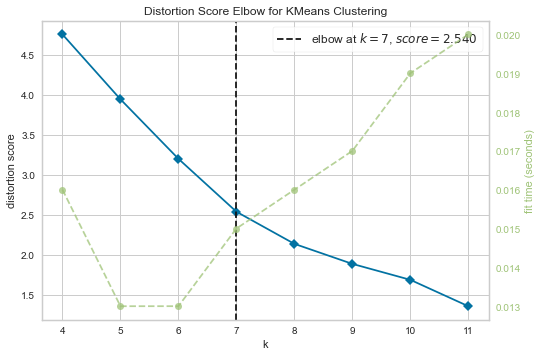

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

ny_grouped_clustering = ny_grouped.drop('city', 1)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(ny_grouped_clustering)
visualizer.show()

In [40]:
k_clusters = 7
ny_grouped_clustering = ny_grouped.drop('city', 1)
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(ny_grouped_clustering)

kmeans.labels_[0:10] 

array([4, 1, 6, 0, 6, 2, 6, 1, 4, 6])

Let's check the top 10 for each neighborhoods including clusters

In [41]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.rename(columns = {'city':'Neighborhood'})
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Donut Shop,Coffee Shop,Smoothie Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café
1,Astoria,Café,Donut Shop,Coffee Shop,Bagel Shop,Dessert Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant
2,Bayside,Donut Shop,Café,Coffee Shop,Bagel Shop,Bakery,Dessert Shop,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant
3,Belle Harbor,Donut Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop
4,Bellerose,Donut Shop,Café,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant,Coffee Shop


In [42]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [43]:
neigh = neighborhoods.loc[neighborhoods['Borough'] == 'Queens']
neigh = neigh[['Neighborhood','Latitude','Longitude']]

neigh.head()

,Neighborhood,Latitude,Longitude
129,Astoria,40.768509,-73.915654
130,Woodside,40.746349,-73.901842
131,Jackson Heights,40.751981,-73.882821
132,Elmhurst,40.744049,-73.881656
133,Howard Beach,40.654225,-73.838138


In [44]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [45]:
ny_merged = neigh
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
129,Astoria,40.768509,-73.915654,1.0,Café,Donut Shop,Coffee Shop,Bagel Shop,Dessert Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant
130,Woodside,40.746349,-73.901842,6.0,Donut Shop,Café,Pub,Coffee Shop,Tea Room,Mediterranean Restaurant,Latin American Restaurant,Bagel Shop,Bakery,Bar
131,Jackson Heights,40.751981,-73.882821,6.0,Donut Shop,Café,Latin American Restaurant,Bubble Tea Shop,Coffee Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley
132,Elmhurst,40.744049,-73.881656,6.0,Donut Shop,Bubble Tea Shop,Café,Chinese Restaurant,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Coffee Shop
133,Howard Beach,40.654225,-73.838138,6.0,Donut Shop,Café,Italian Restaurant,Convenience Store,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop


In [46]:
ny_merged.dropna(inplace=True)

In [47]:
ny_merged['Cluster Labels'] = ny_merged['Cluster Labels'].astype(int)

Let's visualize

In [48]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Clusters Examination

### Cluster 1

In [49]:
ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[0] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
146,Woodhaven,Donut Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop
148,South Ozone Park,Donut Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop
150,Whitestone,Donut Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop
155,Glen Oaks,Donut Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop
162,Queens Village,Donut Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop
163,Hollis,Donut Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop
190,Belle Harbor,Donut Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant,Coffee Shop


### Cluster 2

In [50]:
ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[0] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
129,Astoria,Café,Donut Shop,Coffee Shop,Bagel Shop,Dessert Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant
134,Corona,Donut Shop,Café,Coffee Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant
136,Kew Gardens,Coffee Shop,Donut Shop,Café,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant
138,Flushing,Coffee Shop,Café,Donut Shop,Bakery,Tea Room,Shopping Mall,Greek Restaurant,Bubble Tea Shop,Mediterranean Restaurant,Pub
139,Long Island City,Coffee Shop,Donut Shop,Café,Bar,Dessert Shop,Bagel Shop,Bakery,Bowling Alley,Bubble Tea Shop,Chinese Restaurant
170,Far Rockaway,Café,Coffee Shop,Tea Room,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant


### Cluster 3

In [51]:
ny_merged.loc[ny_merged['Cluster Labels'] == 2, ny_merged.columns[[0] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
147,Ozone Park,Bakery,Café,Tea Room,Dessert Shop,Bagel Shop,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant,Coffee Shop
171,Broad Channel,Café,Tea Room,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant,Coffee Shop
290,Middle Village,Bakery,Café,Tea Room,Dessert Shop,Bagel Shop,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant,Coffee Shop


### Cluster 4

In [52]:
ny_merged.loc[ny_merged['Cluster Labels'] == 3, ny_merged.columns[[0] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
191,Rockaway Park,Mediterranean Restaurant,French Restaurant,Tea Room,Convenience Store,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café


### Cluster 5

In [53]:
ny_merged.loc[ny_merged['Cluster Labels'] == 4, ny_merged.columns[[0] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
140,Sunnyside,Coffee Shop,Donut Shop,Italian Restaurant,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café
141,East Elmhurst,Donut Shop,Coffee Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant
142,Maspeth,Donut Shop,Coffee Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant
153,Little Neck,Donut Shop,Ice Cream Shop,Coffee Shop,Italian Restaurant,Convenience Store,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop
177,Arverne,Donut Shop,Coffee Shop,Smoothie Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café


### Cluster 6

In [54]:
ny_merged.loc[ny_merged['Cluster Labels'] == 5, ny_merged.columns[[0] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
144,Glendale,Coffee Shop,Tea Room,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Café,Chinese Restaurant


### Cluster 7

In [55]:
ny_merged.loc[ny_merged['Cluster Labels'] == 6, ny_merged.columns[[0] + list(range(4, ny_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
130,Woodside,Donut Shop,Café,Pub,Coffee Shop,Tea Room,Mediterranean Restaurant,Latin American Restaurant,Bagel Shop,Bakery,Bar
131,Jackson Heights,Donut Shop,Café,Latin American Restaurant,Bubble Tea Shop,Coffee Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley
132,Elmhurst,Donut Shop,Bubble Tea Shop,Café,Chinese Restaurant,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Coffee Shop
133,Howard Beach,Donut Shop,Café,Italian Restaurant,Convenience Store,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop
135,Forest Hills,Donut Shop,Café,Convenience Store,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant
137,Richmond Hill,Donut Shop,Café,Coffee Shop,Dessert Shop,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant
143,Ridgewood,Donut Shop,Dessert Shop,Café,Bagel Shop,Bakery,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant,Coffee Shop
145,Rego Park,Donut Shop,Bakery,Café,Coffee Shop,Dessert Shop,Bagel Shop,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant
149,College Point,Donut Shop,Bakery,Café,Dessert Shop,Bagel Shop,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant,Coffee Shop
151,Bayside,Donut Shop,Café,Coffee Shop,Bagel Shop,Bakery,Dessert Shop,Bar,Bowling Alley,Bubble Tea Shop,Chinese Restaurant


As you can see over this section, I tried to firstly find the best borough where we could install our business. I had to clean the data many times because the json returned by foursquare didn't always had all the informations. Then I used a k-Mean Clustering to get the similarity between the venues so we know which is the most popular venue category similar to a Café.

## Results and Discussion

Let's discuss about some alternative informations that could give us ideas about how to interpret these data.

First of all I thought it could be interesting to know how the population density is distributed in New York.
I decided to take informations already existing to gain some time.
Here are two maps I found on the web :
    https://viewing.nyc/new-york-city-population-density-mapped/
    https://www.reddit.com/r/MapPorn/comments/afny28/population_density_map_of_new_york_city_and/

The first one was created by Alasdair Rae who is a senior lecturer and researcher Sheffield's University, U.K.
The second one comes from reddit with no further informations.
I need to precise that data sources are important for reliability so the second map will be estimated as less reliable.
We can see that there are mainly two areas of interest :
    - The area from Manhattan to west Bronx with a little part of northern Queens
    - The area near Brooklyn
   
This gives us insight on where population is more dense thus sensitive to enter a café or a donut shop.
Then I decided to take a look on median household in New York as wealth contributes to café lifestyle in general.
So here is a map from the American Community Survey that gives us an idea on wealth distribution in NY :
    https://www.businessinsider.com/new-york-city-income-maps-2014-12?IR=T

We can notice that Manhattan seems to be the ideal place to settle as there is both wealth and population.
Another point to get is that New York is one of the most dense area in the USA.
There is another thing I would like to discuss about map visualizations that could interest a lot of data scientists and analysts.
The simple fact that people are moving has a great impact on these "static maps".
Indeed, traffic is a very important factor that needs to be taken seriously. Venues don't move but people does. 

Here is a video explaining this phenomenon : https://www.youtube.com/watch?v=y1d12A0C9tQ&list=WL&index=26 (It is a French video, so you might not be enable to understand it).
Around 6 minutes and 15 seconds, the youtuber explains that the static population maps aren't good for understanding where people are because people move a lot.
In New York we can see that there is a lower density during the weekend which is a point that we need to take as a parameter.
Also most population visualizations are based on habitation and not on current traffic, which indicates us that the predictions we made can be biased as we also want to get tourists to come visit our cafés.

To counter this problem, a good idea is to use cellphone antennas traffic information during time to see how population density evolves during time.
We knew that there is a lower density during weekends but traffic also change due to seasons (less people in winter that during spring seems intuitive to guess)
cf. "Dynamic population mapping using mobile phone data" : 
https://scholar.google.fr/scholar?q=Dynamic+population+mapping+using+mobile+phone+data&hl=fr&as_sdt=0&as_vis=1&oi=scholart (link to the pdf).


Feel free to bring your opinion or hypotheses in the coursera comments or the start a topic on the coursera forum part. I think it is really intersting.

In result we can see that the best place to start our new business is not quite simple giving the different informations we have.
We can suppose Manhattan as being the most appropriated based on traffic and wealth. The clusters given shows us that Donuts Shops and Coffee Shops are the most popular. So I would propose my boss to make an Hybrid Shop selling coffees and donuts choosing to put "Donuts" in the name of the shop.

## Conclusion

To conclude we can see that simple cafés are not that popular, people prefer Coffee Shops or Donut Shops so we might choose to create our business on these types of venues. We would Settle in Manhattan because it would be more efficient. Due to constaints, the analysis had to be reduced, I found that the northern/west part of Queens was a goo place to settle in. Then according to the clusters Donut Shops are very popular, so we can set the image of our business as a Donut Shop also serving the best Coffee.